# AUDIO EMOTION DETECTION

In [1]:
# Installing the cutom python librabry
!pip install /Users/anoushka/Downloads/emotion_math_utils

Processing ./emotion_math_utils
  Preparing metadata (setup.py) ... done
  Created wheel for emotion-math-utils: filename=emotion_math_utils-0.1-py3-none-any.whl size=2715 sha256=3ca3124a1707ae5db62bf2f5e395c193868a5b7e925a11cc8eade452a1d864e1
  Stored in directory: /private/var/folders/hs/l750sd292jz0lrzlrjzn44180000gn/T/pip-ephem-wheel-cache-8uzdq870/wheels/08/37/67/206476d9f49a2d359769d38ccfef7f99ea927024f237506081
Successfully built emotion-math-utils
  Attempting uninstall: emotion-math-utils
    Found existing installation: emotion-math-utils 0.1
    Uninstalling emotion-math-utils-0.1:
      Successfully uninstalled emotion-math-utils-0.1

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
! pip install librosa


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
! pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import sys
import time
import logging

# Import Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import librosa library which is used to extract data and analyze audio files
import librosa
import librosa.display

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
from tqdm import tqdm

# Import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Use joblib to save and load models
from joblib import dump, load

# Import TensorFlow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential

# Import custom math library
from emotion_math_utils.bryce import root_mean_square
from emotion_math_utils.anoushka import normalize_range
from emotion_math_utils.manila import exp_smooth_pitch

In [6]:
!pip install pysoundfile


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip



## DataSets

In [8]:
crema_d = "/Users/anoushka/Downloads/AudioWAV/"
tess = "/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/"

In [9]:
pd.set_option('display.max_colwidth', None)

### CREMA

### Load the CREMA audio files into a dataframe.

In [10]:
crema_dir = os.listdir(crema_d)

file_emotion = []
file_path = []

emotions = {'SAD' : 'sad',
            'ANG' : 'angry',
            'DIS' : 'disgust',
            'FEA' : 'fear',
            'HAP' : 'happy',
            'NEU' : 'neutral'}

for file in crema_dir:
    # storing file paths
    file_path.append(crema_d + file)
    # storing file emotions
    part=file.split('_')
    if part[2] in emotions:
        file_emotion.append(emotions[part[2]])
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
angry      1271
disgust    1271
sad        1271
fear       1271
happy      1271
neutral    1087
Name: count, dtype: int64


### TESS

### Load the TESS data files into a Data Frame

In [11]:
tess_directory_list = os.listdir(tess)

In [12]:
tess_directory_list

['YAF_disgust',
 'OAF_Pleasant_surprise',
 'OAF_happy',
 'YAF_sad',
 'YAF_happy',
 'YAF_neutral',
 'OAF_Fear',
 'OAF_angry',
 'YAF_pleasant_surprised',
 'YAF_fear',
 'OAF_neutral',
 'OAF_disgust',
 'YAF_angry',
 'OAF_Sad']

In [13]:
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

# Iterate through each directory in the TESS list
for directory in tess_directory_list:
    # Full path to the directory
    directory_path = os.path.join(tess, directory)
    # List all files within the directory
    files = os.listdir(directory_path)

    for file in files:
        # Remove the file extension and split by '_'
        parts = file.split('.')[0].split('_')

        # Ensure there are enough parts to determine the emotion
        if len(parts) >= 3:
            emotion = parts[2]
            # Map 'ps' to 'surprise' and append the result
            emotion = 'surprise' if emotion == 'ps' else emotion
            file_emotion.append(emotion)
        else:
            # Handle files without sufficient parts to determine the emotion
            file_emotion.append(None)  # Consider logging this case or handling it differently

        # Append the full path of the file
        file_path.append(os.path.join(directory_path, file))

# Create DataFrame for emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create DataFrame for file paths
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate both DataFrames horizontally
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the DataFrame
print(Tess_df.head())

# Print the count of each emotion to see the distribution
print(Tess_df.Emotions.value_counts())

  Emotions  \
0  disgust   
1  disgust   
2  disgust   
3  disgust   
4  disgust   

                                                                                     Path  
0   /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_disgust/YAF_date_disgust.wav  
1    /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_disgust/YAF_rag_disgust.wav  
2  /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_disgust/YAF_raise_disgust.wav  
3  /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_disgust/YAF_ditch_disgust.wav  
4   /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_disgust/YAF_door_disgust.wav  
Emotions
disgust     400
surprise    400
happy       400
sad         400
neutral     400
fear        400
angry       400
Name: count, dtype: int64


In [14]:
Crema_df['source'] = 'CREMA-D'
Tess_df['source'] = 'TESS'

In [15]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path,source
0,angry,/Users/anoushka/Downloads/AudioWAV/1022_ITS_ANG_XX.wav,CREMA-D
1,angry,/Users/anoushka/Downloads/AudioWAV/1037_ITS_ANG_XX.wav,CREMA-D
2,neutral,/Users/anoushka/Downloads/AudioWAV/1060_ITS_NEU_XX.wav,CREMA-D
3,neutral,/Users/anoushka/Downloads/AudioWAV/1075_ITS_NEU_XX.wav,CREMA-D
4,disgust,/Users/anoushka/Downloads/AudioWAV/1073_IOM_DIS_XX.wav,CREMA-D


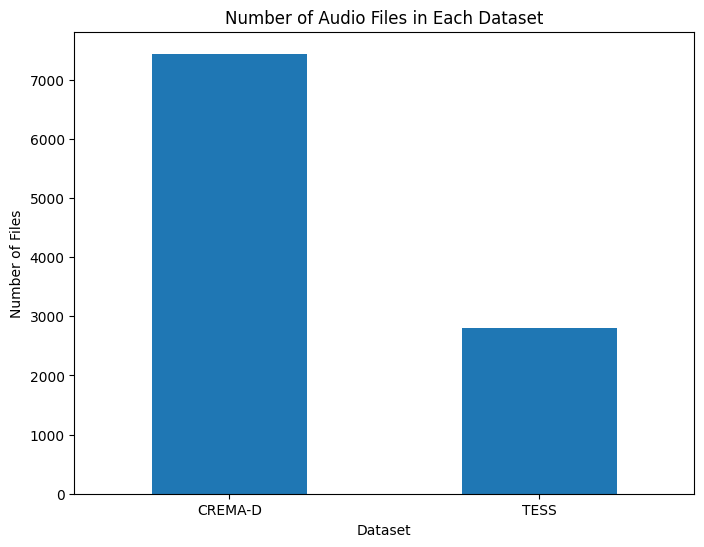

In [16]:
import matplotlib.pyplot as plt

# Count the number of files in each dataset
file_counts = data_path['source'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
file_counts.plot(kind='bar')
plt.title('Number of Audio Files in Each Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Files')
plt.xticks(rotation=0)  # Rotate labels to be horizontal
plt.show()

In [17]:
data_path.head

<bound method NDFrame.head of      Emotions  \
0       angry   
1       angry   
2     neutral   
3     neutral   
4     disgust   
...       ...   
2795      sad   
2796      sad   
2797      sad   
2798      sad   
2799      sad   

                                                                                Path  \
0                             /Users/anoushka/Downloads/AudioWAV/1022_ITS_ANG_XX.wav   
1                             /Users/anoushka/Downloads/AudioWAV/1037_ITS_ANG_XX.wav   
2                             /Users/anoushka/Downloads/AudioWAV/1060_ITS_NEU_XX.wav   
3                             /Users/anoushka/Downloads/AudioWAV/1075_ITS_NEU_XX.wav   
4                             /Users/anoushka/Downloads/AudioWAV/1073_IOM_DIS_XX.wav   
...                                                                              ...   
2795   /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_Sad/OAF_tool_sad.wav   
2796  /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OA

In [18]:
data_path['Path']

0                               /Users/anoushka/Downloads/AudioWAV/1022_ITS_ANG_XX.wav
1                               /Users/anoushka/Downloads/AudioWAV/1037_ITS_ANG_XX.wav
2                               /Users/anoushka/Downloads/AudioWAV/1060_ITS_NEU_XX.wav
3                               /Users/anoushka/Downloads/AudioWAV/1075_ITS_NEU_XX.wav
4                               /Users/anoushka/Downloads/AudioWAV/1073_IOM_DIS_XX.wav
                                             ...                                      
2795     /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_Sad/OAF_tool_sad.wav
2796    /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_Sad/OAF_goose_sad.wav
2797      /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_Sad/OAF_met_sad.wav
2798    /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_Sad/OAF_pearl_sad.wav
2799     /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_Sad/OAF_rain_sad.wav
Name: Path, Length: 10242, dtype: object

### Displaying Data Categories

In [19]:
import pandas as pd

# Load the dataset
data_path = "data_path.csv"
emotion_df = pd.read_csv(data_path)

# Remove rows with "Surprise" class
emotion_df = emotion_df[emotion_df['Emotions'] != 'surprise']

# Count the number of rows for each class
class_counts = emotion_df['Emotions'].value_counts()

# Remove 300 rows from each class except "happy" and "neutral"
rows_to_keep = []
for emotion, count in class_counts.items():
    if emotion in ['happy', 'neutral']:
        rows_to_keep.extend(emotion_df[emotion_df['Emotions'] == emotion].index)
    else:
        # Ensure that count - 900 is not negative
        num_to_sample = max(count - 900, 0)
        rows_to_keep.extend(emotion_df[emotion_df['Emotions'] == emotion].sample(n=num_to_sample, random_state=42).index)


# Filter the dataset to keep only the selected rows
emotion_df = emotion_df.loc[rows_to_keep]

# Check the new distribution of emotion classes
print(emotion_df['Emotions'].value_counts())

# Save the updated dataset
emotion_df.to_csv("balanced_data.csv", index=False)

Emotions
happy      1671
neutral    1487
angry       771
disgust     771
sad         771
fear        771
Name: count, dtype: int64


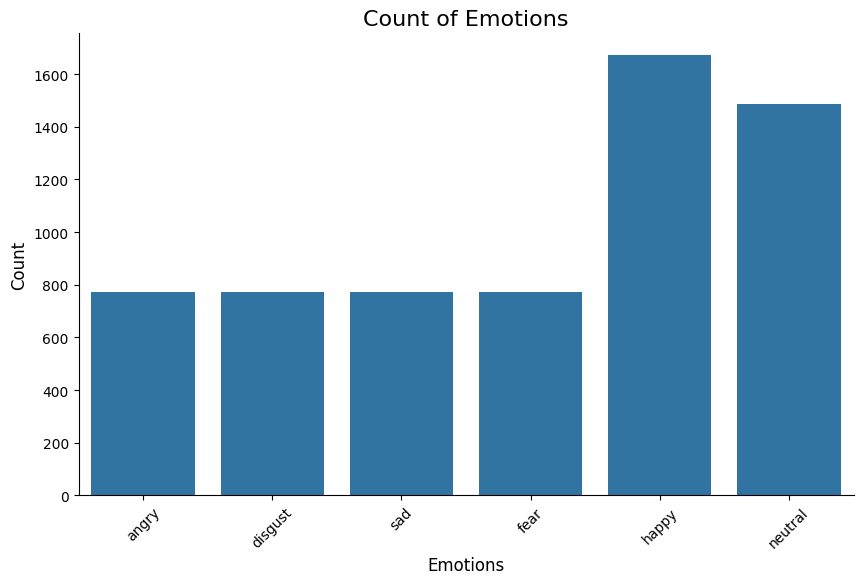

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example dataframe, replace this with your actual dataframe loading line
data_path = "balanced_data.csv"
emotion_df = pd.read_csv(data_path)

plt.figure(figsize=(10, 6))  # Adjust the size of your plot as needed
plt.title('Count of Emotions', size=16)
sns.countplot(x=emotion_df['Emotions'])  # Ensure that 'Emotions' is the name of your column
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)  # Clean up frame visibility
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.show()


In [21]:
# Save the updated dataset
emotion_df.to_csv("balanced_data.csv", index=False)

In [22]:
emotion_df

,Emotions,Path,source
0,angry,/Users/anoushka/Downloads/AudioWAV/1091_IEO_ANG_LO.wav,CREMA-D
1,angry,/Users/anoushka/Downloads/AudioWAV/1042_IEO_ANG_HI.wav,CREMA-D
2,angry,/Users/anoushka/Downloads/AudioWAV/1044_TAI_ANG_XX.wav,CREMA-D
3,angry,/Users/anoushka/Downloads/AudioWAV/1034_IEO_ANG_HI.wav,CREMA-D
4,angry,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_angry/YAF_wheat_angry.wav,TESS
...,...,...,...
6237,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_room_neutral.wav,TESS
6238,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_king_neutral.wav,TESS
6239,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_gap_neutral.wav,TESS
6240,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_chair_neutral.wav,TESS


In [23]:
! pip install --upgrade librosa soundfile
! pip install --upgrade librosa soundfile


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [24]:
file_path[0]

'/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_disgust/YAF_date_disgust.wav'

In [28]:
!pip uninstall soundfile -y
!pip install soundfile


  Using cached soundfile-0.13.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (16 kB)
Using cached soundfile-0.13.1-py2.py3-none-macosx_11_0_arm64.whl (1.1 MB)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [29]:
data,sr = librosa.load(file_path[0])
sr

22050

In [30]:
file_path[0]

'/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_disgust/YAF_date_disgust.wav'

In [31]:
emotion_df

,Emotions,Path,source
0,angry,/Users/anoushka/Downloads/AudioWAV/1091_IEO_ANG_LO.wav,CREMA-D
1,angry,/Users/anoushka/Downloads/AudioWAV/1042_IEO_ANG_HI.wav,CREMA-D
2,angry,/Users/anoushka/Downloads/AudioWAV/1044_TAI_ANG_XX.wav,CREMA-D
3,angry,/Users/anoushka/Downloads/AudioWAV/1034_IEO_ANG_HI.wav,CREMA-D
4,angry,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_angry/YAF_wheat_angry.wav,TESS
...,...,...,...
6237,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_room_neutral.wav,TESS
6238,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_king_neutral.wav,TESS
6239,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_gap_neutral.wav,TESS
6240,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_chair_neutral.wav,TESS


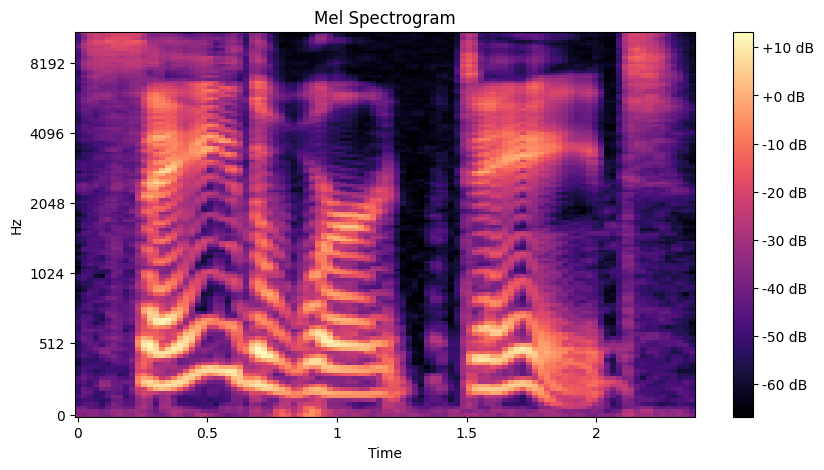

In [32]:
# Set the dimensions for the plot
plt.figure(figsize=(10, 5))
# Compute the Mel spectrogram
n_mels = 128
fmax = 8000
mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)

# Convert the Mel spectrogram to log scale (for better visualization)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# Display the spectrogram
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')

# Add a title to the plot
plt.title('Mel Spectrogram')

# Add a color bar with label formatting
plt.colorbar(format='%+2.0f dB')

# Show the plot
plt.show()

ipd.Audio(data,rate=sr)

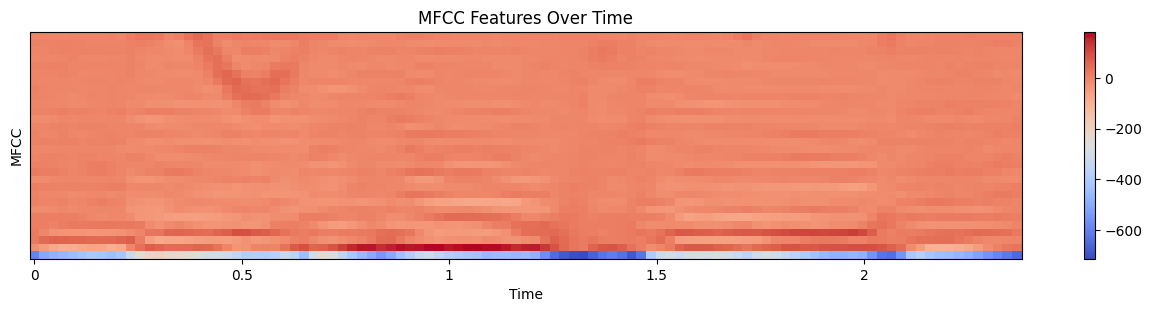

In [33]:
# Create a larger plot to display the MFCC
plt.figure(figsize=(16, 10))

# Compute the MFCC (Mel Frequency Cepstral Coefficients)
n_mfcc = 30
mfcc_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)

# Add a subplot with specific dimensions
plt.subplot(3, 1, 1)  # (rows, columns, panel number)

# Display the MFCC using librosa's specshow function
librosa.display.specshow(mfcc_features, sr=sr, x_axis='time')

# Label the y-axis as 'MFCC'
plt.ylabel('MFCC')

# Add a colorbar to show the scale
plt.colorbar()

# Optionally, you might want to add a title or additional subplots
plt.title('MFCC Features Over Time')

# Display the plot
plt.show()

ipd.Audio(data,rate=sr)

### Data Augmentation

In [34]:
def noise(data):
    noise_amplitude = 0.035 * np.random.uniform() * np.amax(data)
    noise = noise_amplitude * np.random.normal(size=data.shape[0])
    return data + noise

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [35]:
emotion_df

,Emotions,Path,source
0,angry,/Users/anoushka/Downloads/AudioWAV/1091_IEO_ANG_LO.wav,CREMA-D
1,angry,/Users/anoushka/Downloads/AudioWAV/1042_IEO_ANG_HI.wav,CREMA-D
2,angry,/Users/anoushka/Downloads/AudioWAV/1044_TAI_ANG_XX.wav,CREMA-D
3,angry,/Users/anoushka/Downloads/AudioWAV/1034_IEO_ANG_HI.wav,CREMA-D
4,angry,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_angry/YAF_wheat_angry.wav,TESS
...,...,...,...
6237,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_room_neutral.wav,TESS
6238,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_king_neutral.wav,TESS
6239,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_gap_neutral.wav,TESS
6240,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_chair_neutral.wav,TESS


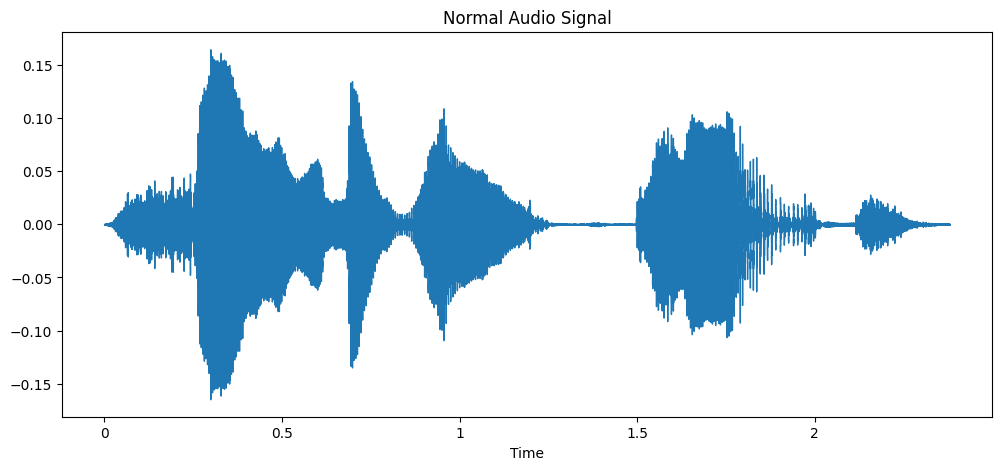

In [36]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
plt.title("Normal Audio Signal")
ipd.Audio(data,rate=sr)

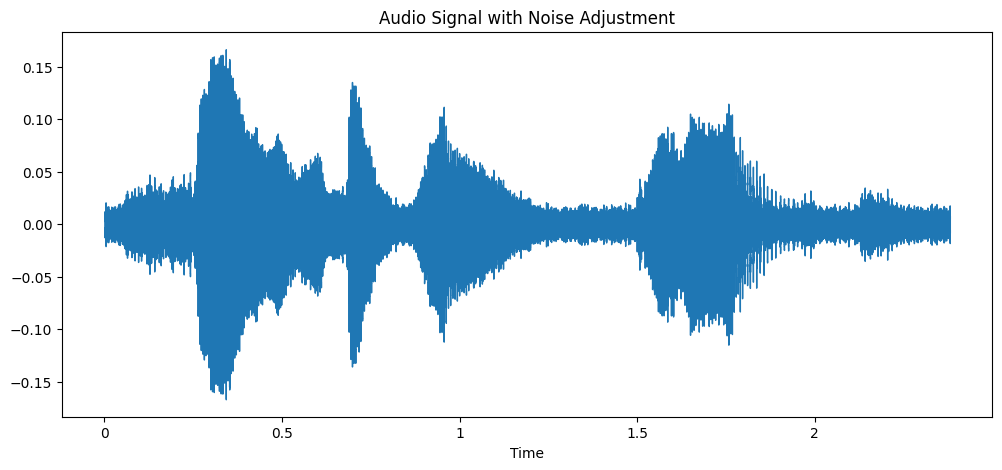

In [37]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
plt.title("Audio Signal with Noise Adjustment")
ipd.Audio(x, rate=sr)

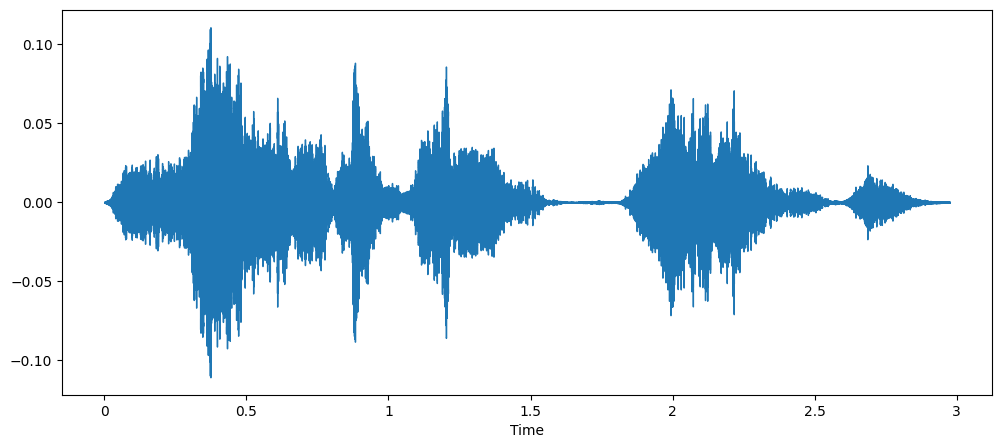

In [38]:
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

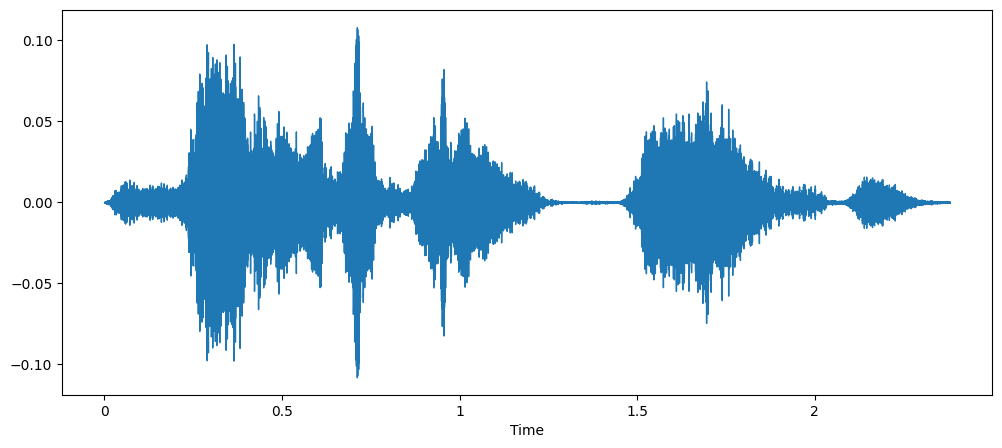

In [39]:
# SHIFT
def shift(data, sr):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=4)


# SHIFTED AUDIO
x = shift(data, sr)  # Pass the sampling rate to the shift function
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

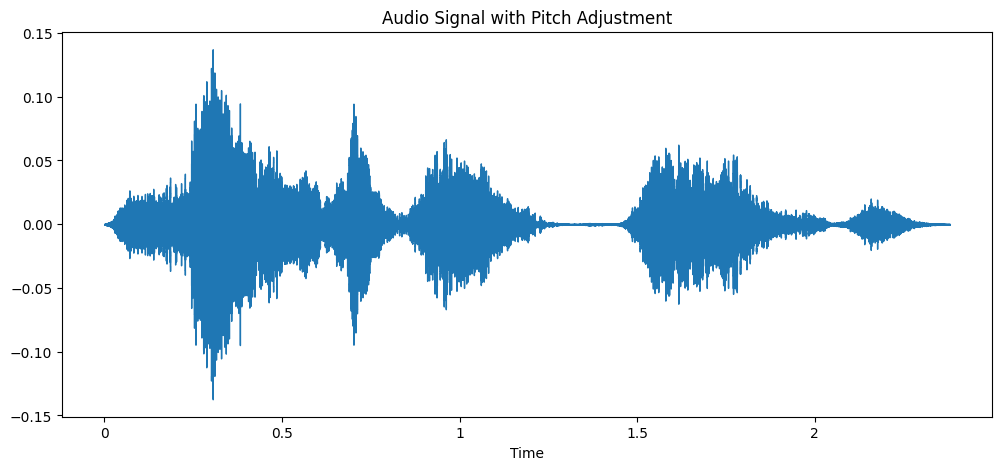

In [40]:
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
plt.title("Audio Signal with Pitch Adjustment")
ipd.Audio(x, rate=sr)

### Using Custom math function from the library

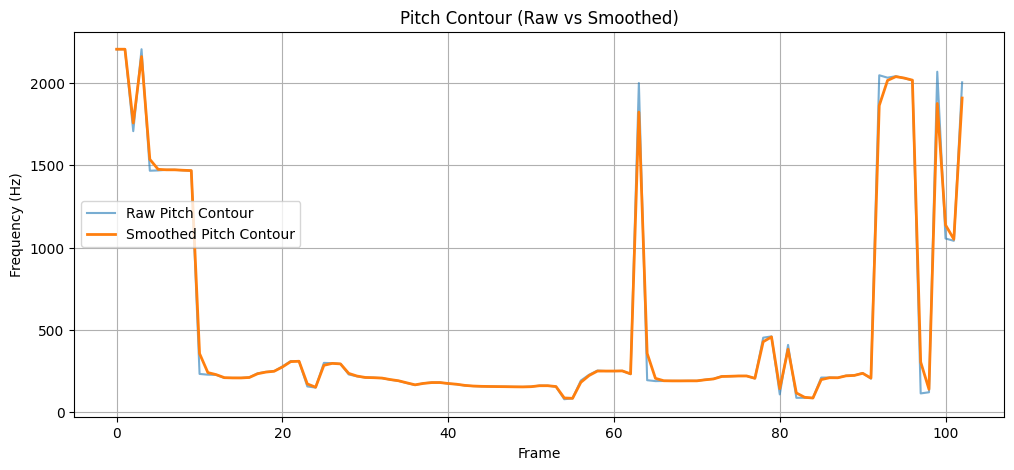

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Extract pitch contour using librosa.yin
f0_raw = librosa.yin(y=data, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
f0_smoothed = exp_smooth_pitch(f0_raw)

# Plot both raw and smoothed pitch contours
plt.figure(figsize=(12, 5))
plt.plot(f0_raw, label='Raw Pitch Contour', alpha=0.6)
plt.plot(f0_smoothed, label='Smoothed Pitch Contour', linewidth=2)
plt.title("Pitch Contour (Raw vs Smoothed)")
plt.xlabel("Frame")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.grid(True)
plt.show()


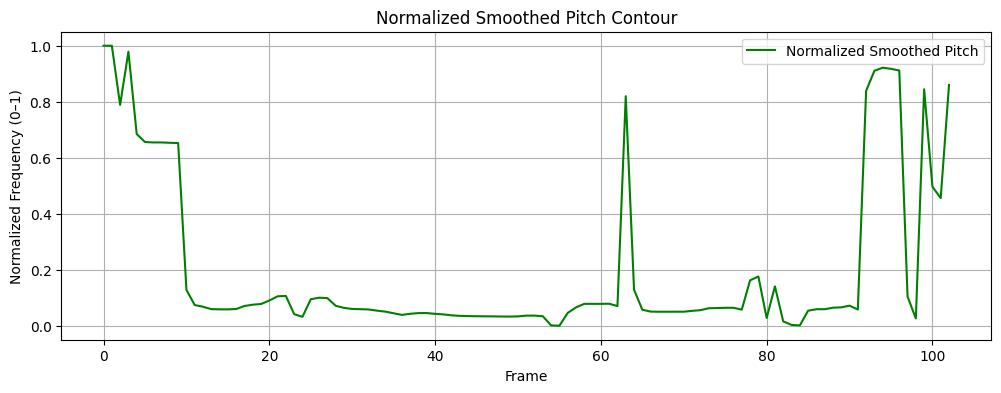

In [114]:
#normalize the smoothed pitch
f0_norm = normalize_range(0, len(f0_smoothed), f0_smoothed)

# Plot normalized smoothed pitch
plt.figure(figsize=(12, 4))
plt.plot(f0_norm, label='Normalized Smoothed Pitch', color='green')
plt.title("Normalized Smoothed Pitch Contour")
plt.xlabel("Frame")
plt.ylabel("Normalized Frequency (0–1)")
plt.grid(True)
plt.legend()
plt.show()

### Feature Extraction

In [44]:
def calculate_zcr(data, frame_length, hop_length):
    return np.squeeze(librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length))

def calculate_rmse(data, frame_length=2048, hop_length=512):
    return np.squeeze(librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length))

def calculate_mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, n_fft=frame_length, hop_length=hop_length)
    return np.ravel(mfccs.T) if flatten else np.squeeze(mfccs.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    features = np.hstack((
        calculate_zcr(data, frame_length, hop_length),
        calculate_rmse(data, frame_length, hop_length),
        calculate_mfcc(data, sr, frame_length, hop_length)
    ))
    return features

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data, sr)

    # Original and augmented audio feature extraction
    transformations = [
        data,  # original
        noise(data),  # added noise
        pitch(data, sr),  # pitch shifted
        noise(pitch(data, sr))  # noise added to pitch shifted
    ]

    feature_matrix = np.array([extract_features(transformed, sr) for transformed in transformations])

    return feature_matrix



In [45]:
emotion_df

,Emotions,Path,source
0,angry,/Users/anoushka/Downloads/AudioWAV/1091_IEO_ANG_LO.wav,CREMA-D
1,angry,/Users/anoushka/Downloads/AudioWAV/1042_IEO_ANG_HI.wav,CREMA-D
2,angry,/Users/anoushka/Downloads/AudioWAV/1044_TAI_ANG_XX.wav,CREMA-D
3,angry,/Users/anoushka/Downloads/AudioWAV/1034_IEO_ANG_HI.wav,CREMA-D
4,angry,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_angry/YAF_wheat_angry.wav,TESS
...,...,...,...
6237,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_room_neutral.wav,TESS
6238,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_king_neutral.wav,TESS
6239,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_gap_neutral.wav,TESS
6240,neutral,/Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_chair_neutral.wav,TESS


In [46]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


### Features Extraction

In [47]:
print(emotion_df.columns)

Index(['Emotions', 'Path', 'source'], dtype='object')


In [48]:
print(emotion_df['Emotions'].unique())

['angry' 'disgust' 'sad' 'fear' 'happy' 'neutral']


In [49]:
print(emotion_df)

     Emotions  \
0       angry   
1       angry   
2       angry   
3       angry   
4       angry   
...       ...   
6237  neutral   
6238  neutral   
6239  neutral   
6240  neutral   
6241  neutral   

                                                                                        Path  \
0                                     /Users/anoushka/Downloads/AudioWAV/1091_IEO_ANG_LO.wav   
1                                     /Users/anoushka/Downloads/AudioWAV/1042_IEO_ANG_HI.wav   
2                                     /Users/anoushka/Downloads/AudioWAV/1044_TAI_ANG_XX.wav   
3                                     /Users/anoushka/Downloads/AudioWAV/1034_IEO_ANG_HI.wav   
4         /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/YAF_angry/YAF_wheat_angry.wav   
...                                                                                      ...   
6237   /Users/anoushka/Downloads/tess/tess_data_set/tess_ds/OAF_neutral/OAF_room_neutral.wav   
6238   /Users/anoushka/Down

In [50]:
print(emotion_df.iloc[0])

Emotions                                                     angry
Path        /Users/anoushka/Downloads/AudioWAV/1091_IEO_ANG_LO.wav
source                                                     CREMA-D
Name: 0, dtype: object


In [51]:
print(emotion_df['Emotions'])

0         angry
1         angry
2         angry
3         angry
4         angry
         ...   
6237    neutral
6238    neutral
6239    neutral
6240    neutral
6241    neutral
Name: Emotions, Length: 6242, dtype: object


In [52]:
data

array([ 9.1582027e-05,  1.8023457e-04,  5.7952362e-05, ...,
        2.6570293e-05,  1.5847781e-04, -2.9533535e-06], dtype=float32)

In [53]:
emotion_df.shape

(6242, 3)

In [54]:
def extract_features_and_labels(emotion_df):
    X, Y = [], []

    # Start timing the operation
    start_time = time.time()

    # Use tqdm for progress tracking
    for path, emotion in tqdm(zip(emotion_df['Path'], emotion_df['Emotions']), total=len(emotion_df)):
        try:
            # Extract features for each audio file path
            features = get_features(path)
            for feature in features:
                X.append(feature)
                Y.append(emotion)
        except Exception as e:
            logging.error(f"Error processing file: {path}, {e}")

    # End timing the operation
    elapsed_time = time.time() - start_time
    print('Done')
    print(f'Time: {elapsed_time:.2f} seconds')

    return X, Y


X, Y = extract_features_and_labels(emotion_df)

100%|██████████| 6242/6242 [26:43<00:00,  3.89it/s]   

Done
Time: 1603.41 seconds


In [55]:
len(X), len(Y), emotion_df.Emotions.shape

(24968, 24968, (6242,))

### Handle Missing and Null Values

In [56]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.029785,0.043945,0.055664,0.050781,0.053711,0.051270,0.044434,0.040527,0.040527,0.058105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
1,0.029785,0.043945,0.057617,0.055664,0.058105,0.057129,0.050293,0.046387,0.051270,0.069824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
2,0.031738,0.046875,0.066895,0.064941,0.060547,0.051270,0.040527,0.033691,0.033203,0.060547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
3,0.030762,0.052734,0.097168,0.111816,0.117188,0.109863,0.086426,0.072754,0.093262,0.143066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
4,0.039551,0.061035,0.077148,0.138672,0.201660,0.263184,0.263184,0.203125,0.142090,0.070801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry


In [57]:
Emotions.shape

(24968, 1621)

In [58]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.029785,0.043945,0.055664,0.050781,0.053711,0.051270,0.044434,0.040527,0.040527,0.058105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
1,0.029785,0.043945,0.057617,0.055664,0.058105,0.057129,0.050293,0.046387,0.051270,0.069824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
2,0.031738,0.046875,0.066895,0.064941,0.060547,0.051270,0.040527,0.033691,0.033203,0.060547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
3,0.030762,0.052734,0.097168,0.111816,0.117188,0.109863,0.086426,0.072754,0.093262,0.143066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
4,0.039551,0.061035,0.077148,0.138672,0.201660,0.263184,0.263184,0.203125,0.142090,0.070801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry


In [59]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
1616         True
1617         True
1618         True
1619         True
Emotions    False
Length: 1621, dtype: bool


In [60]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
1616        False
1617        False
1618        False
1619        False
Emotions    False
Length: 1621, dtype: bool


(24968, 1621)

In [61]:
np.sum(Emotions.isna())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
1616        0
1617        0
1618        0
1619        0
Emotions    0
Length: 1621, dtype: int64

## Data Preparation for KNN and Random Forest Models

In [62]:
x_val = Emotions.iloc[: ,:-1].values
y_emotions = Emotions['Emotions'].values

In [63]:
from sklearn.preprocessing import LabelEncoder


# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform labels to integers
Y_encoded = label_encoder.fit_transform(y_emotions)

print("Encoded labels:", Y_encoded)

Encoded labels: [0 0 0 ... 4 4 4]


In [64]:
x_train, x_test, y_train, y_test = train_test_split(x_val, Y_encoded, test_size=0.2, random_state=42)

In [65]:
len(y_train)

19974

In [66]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19974, 1620), (19974,), (4994, 1620), (4994,))

### KNN Model with GridSearchCV

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Set the parameters by cross-validation
tuned_parameters = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

clf = GridSearchCV(
    KNeighborsClassifier(metric='manhattan'), tuned_parameters, cv=3,
    scoring='accuracy', verbose=3
)

clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ....n_neighbors=3, weights=uniform;, score=0.596 total time=  23.2s
[CV 2/3] END ....n_neighbors=3, weights=uniform;, score=0.593 total time=  23.3s
[CV 3/3] END ....n_neighbors=3, weights=uniform;, score=0.594 total time=  23.4s
[CV 1/3] END ...n_neighbors=3, weights=distance;, score=0.704 total time=  21.2s
[CV 2/3] END ...n_neighbors=3, weights=distance;, score=0.700 total time=  21.2s
[CV 3/3] END ...n_neighbors=3, weights=distance;, score=0.700 total time=  22.2s
[CV 1/3] END ....n_neighbors=5, weights=uniform;, score=0.570 total time=32.9min
[CV 2/3] END ....n_neighbors=5, weights=uniform;, score=0.561 total time=  24.2s
[CV 3/3] END ....n_neighbors=5, weights=uniform;, score=0.558 total time=  23.5s
[CV 1/3] END ...n_neighbors=5, weights=distance;, score=0.661 total time=  21.3s
[CV 2/3] END ...n_neighbors=5, weights=distance;, score=0.655 total time=  21.3s
[CV 3/3] END ...n_neighbors=5, weights=distance;,

In [ ]:
# uncomment to save the trained model
# dump(clf, "knnClassifier.joblib")

In [76]:
clf_saved = load('knnClassifier.joblib')

In [78]:
# Predicting the test set results
y_pred_clf= clf_saved.best_estimator_.predict(x_test)

In [79]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy_clf = accuracy_score(y_test, y_pred_clf)
print(f"Accuracy: {accuracy_clf*100:.2f}%")

# More detailed report
print("Classification Report:")
print(classification_report(y_test, y_pred_clf))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_clf))

Accuracy: 79.92%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       616
           1       0.82      0.74      0.78       632
           2       0.74      0.73      0.74       604
           3       0.84      0.83      0.83      1320
           4       0.79      0.83      0.81      1187
           5       0.69      0.80      0.74       635

    accuracy                           0.80      4994
   macro avg       0.80      0.79      0.79      4994
weighted avg       0.80      0.80      0.80      4994

Confusion Matrix:
[[ 497   21   17   52   21    8]
 [   5  470   21   43   43   50]
 [  19   10  443   41   38   53]
 [  21   22   41 1094  110   32]
 [   7   25   37   57  982   79]
 [   0   23   42   18   47  505]]


### Random Forest Model

In [80]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, min_samples_split=2, verbose=3)

# Train the classifier
rf.fit(x_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   12.9s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

RandomForestClassifier(max_depth=20, random_state=42, verbose=3)

In [82]:
# dump(rf, "randomForest.joblib")

['randomForest.joblib']

In [83]:
rf_saved = load("randomForest.joblib")

In [84]:
y_pred_rf = rf_saved.predict(x_test)

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s


In [85]:
accuracy_clf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_clf*100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# # Confusion Matrix
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 73.43%
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       616
           1       0.78      0.59      0.67       632
           2       0.94      0.48      0.63       604
           3       0.71      0.82      0.76      1320
           4       0.64      0.88      0.74      1187
           5       0.80      0.68      0.74       635

    accuracy                           0.73      4994
   macro avg       0.79      0.70      0.72      4994
weighted avg       0.76      0.73      0.73      4994



### Data Preparation for CNN

In [87]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [88]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [89]:
print(Y.shape)
X.shape

(24968, 6)


(24968, 1620)

In [90]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19974, 1620), (19974, 6), (4994, 1620), (4994, 6))

In [91]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [92]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19974, 1620), (19974, 6), (4994, 1620), (4994, 6))

In [93]:
# Setup callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# Setup learning rate reduction
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_accuracy', mode='auto', verbose=1)

## CNN Model

In [94]:
#Reshape for CNN MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((19974, 1620, 1), (19974, 6), (4994, 1620, 1), (4994, 6))

In [95]:
import tensorflow.keras.layers as L
import tensorflow as tf

# Simplified model
model = tf.keras.Sequential([
    # Reduce the number of filters in the convolutional layers
    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),

    # Remove one Conv1D layer to reduce complexity
    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),  # Maintain dropout for regularization

    # Flatten the output of the convolutional layers to feed into the dense layer
    L.Flatten(),

    # Reduce the number of neurons in the dense layer
    L.Dense(256, activation='relu'),
    L.BatchNormalization(),

    # Output layer: keep the same as the number of categories in the target classification
    L.Dense(6, activation='softmax')
])

# Compile the above model with optimizer, metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to see the model information
model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1620, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1620, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 810, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 810, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 810, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 405, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 405, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,271,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,374,854 (51.02 MB)

 Trainable params: 13,373,574 (51.02 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [96]:
history=model.fit(x_traincnn, y_train, epochs=20, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stopping,lr_reduction,model_checkpoint])

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.4003 - loss: 1.6774
Epoch 1: val_accuracy improved from -inf to 0.12135, saving model to model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 373ms/step - accuracy: 0.4005 - loss: 1.6766 - val_accuracy: 0.1213 - val_loss: 26.5320 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.5580 - loss: 1.1499
Epoch 2: val_accuracy improved from 0.12135 to 0.48618, saving model to model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 261s 836ms/step - accuracy: 0.5580 - loss: 1.1498 - val_accuracy: 0.4862 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.6197 - loss: 0.9978
Epoch 3: val_accuracy improved from 0.48618 to 0.58630, saving model to model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 165s 528ms/step - accuracy: 0.6198 - loss: 0.9977 - val_accuracy: 0.5863 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step 

In [97]:
dump(model, "cnnClassifier.joblib")

['cnnClassifier.joblib']

In [98]:
cnn_saved = load("cnnClassifier.joblib")

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9575 - loss: 0.1498
Accuracy of our model on test data :  95.47457098960876 %


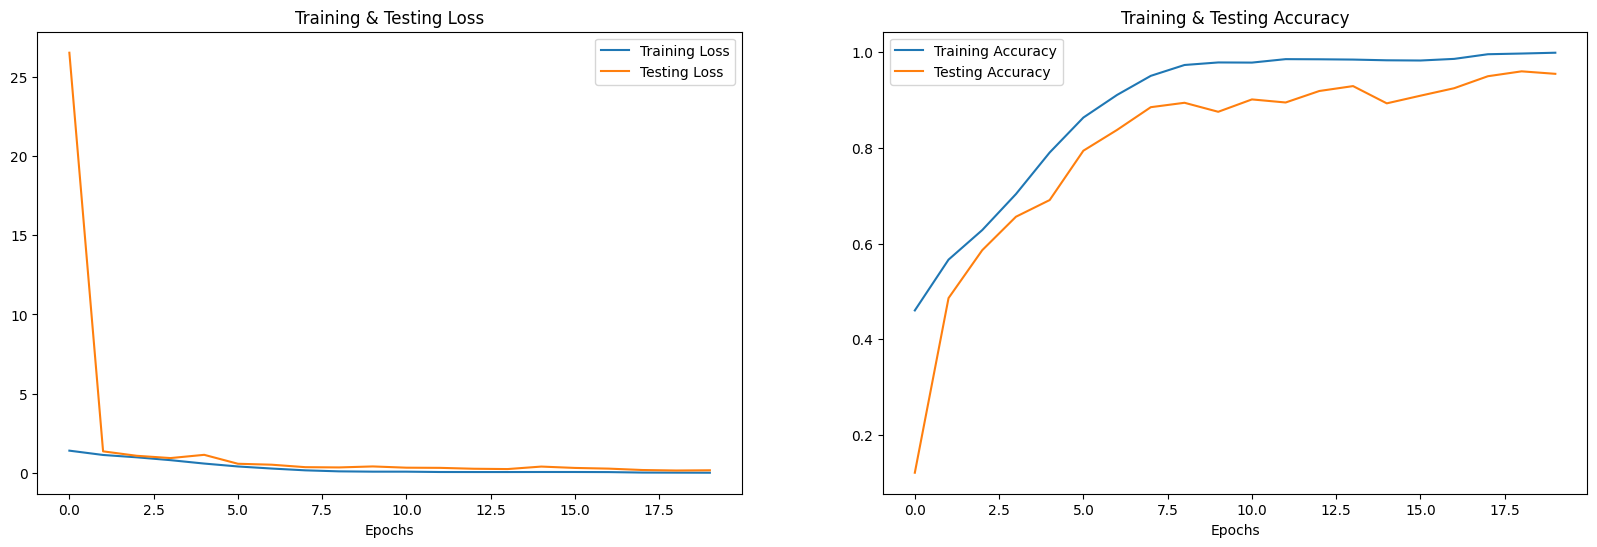

In [99]:
print("Accuracy of our model on test data : " , cnn_saved.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [101]:
# predicting on test data.
pred_test0 = cnn_saved.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [102]:
df0

,Predicted Labels,Actual Labels
0,neutral,neutral
1,disgust,disgust
2,disgust,neutral
3,sad,sad
4,happy,happy
...,...,...
4989,disgust,disgust
4990,happy,happy
4991,sad,sad
4992,happy,happy


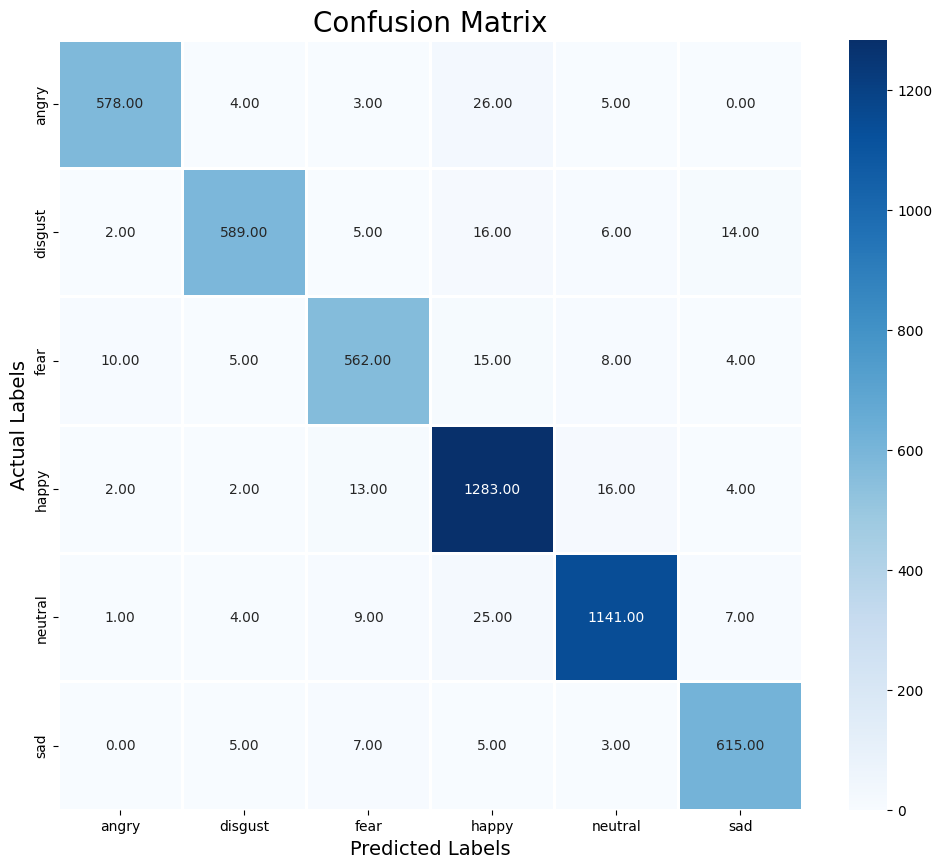

              precision    recall  f1-score   support

       angry       0.97      0.94      0.96       616
     disgust       0.97      0.93      0.95       632
        fear       0.94      0.93      0.93       604
       happy       0.94      0.97      0.95      1320
     neutral       0.97      0.96      0.96      1187
         sad       0.95      0.97      0.96       635

    accuracy                           0.95      4994
   macro avg       0.96      0.95      0.95      4994
weighted avg       0.96      0.95      0.95      4994



In [103]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Model Comparision

# Random Forest

Accuracy: 73.23%   
Precision (Macro Average): 0.79  
Recall (Macro Average): 0.69  
F1 Score (Macro Average): 0.71

## KNN Model

Accuracy: 79.32%   
Precision (Macro Average): 0.80    
Recall (Macro Average): 0.79    
F1 Score (Macro Average): 0.79    

## CNN Model
Accuracy: 95%    
Precision (Macro Average): 0.95  
Recall (Macro Average): 0.94  
F1 Score (Macro Average): 0.94  

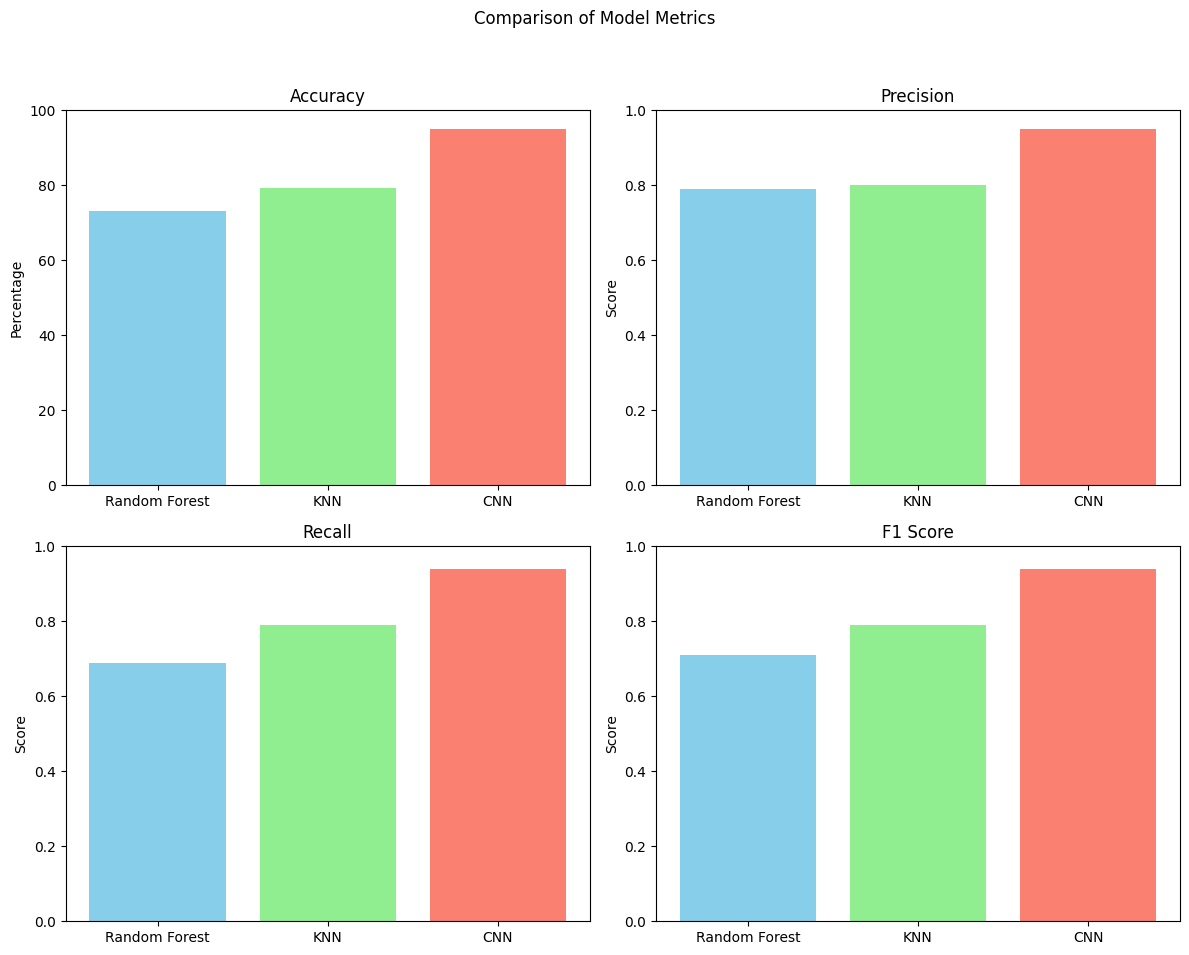

In [108]:
import matplotlib.pyplot as plt

# Data from the classification reports for each model
models = ['Random Forest', 'KNN', 'CNN']
accuracy = [73.23, 79.32, 95]
precision = [0.79, 0.80, 0.95]
recall = [0.69, 0.79, 0.94]
f1_score = [0.71, 0.79, 0.94]

# Creating subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparison of Model Metrics')

# Custom colors for the plots
colors = ['skyblue', 'lightgreen', 'salmon']

# Plotting accuracy
ax[0, 0].bar(models, accuracy, color=colors)
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylabel('Percentage')
ax[0, 0].set_ylim([0, 100])

# Plotting precision
ax[0, 1].bar(models, precision, color=colors)
ax[0, 1].set_title('Precision')
ax[0, 1].set_ylabel('Score')
ax[0, 1].set_ylim([0, 1])

# Plotting recall
ax[1, 0].bar(models, recall, color=colors)
ax[1, 0].set_title('Recall')
ax[1, 0].set_ylabel('Score')
ax[1, 0].set_ylim([0, 1])

# Plotting F1-score
ax[1, 1].bar(models, f1_score, color=colors)
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_ylabel('Score')
ax[1, 1].set_ylim([0, 1])

# Show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
